In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import talib.abstract as ta
import tensorflow
import copy

In [2]:
def readData(filename):
    convertfunc = lambda x: (pd.to_datetime(x,utc=True)).tz_convert('Asia/Kolkata')
    return pd.read_csv(filename,
                    names=["DateTime","open","high","low","close","volume"],
                    dtype=None,
                    delimiter = ',',
                    converters = {0:convertfunc},
                  #  index_col = 0
                   )

In [3]:
A2Z = readData("data/A2Z.csv")
Nifty50 = readData("data/Nifty50.csv")

In [4]:
# Making sure that 2 timeseries are synced to the smaller time series 
def sanitizeTimeSeries(ts1,ts2):
    # If TS1 is not bigger, then make TS1 the bigger one and TS2 the smaller one.
    flipped = 0
    if len(ts2) > len(ts1):
        flipped = 1
        ts1,ts2 = ts2,ts1
    for dt in ts1["DateTime"].values:
        if dt in ts2['DateTime'].values:
            continue
        else:
            #print(dt)
            ts1.drop(ts1[ts1["DateTime"]==dt].index,inplace = True)
    if flipped:
        return ts2, ts1.reset_index(drop = True)
    else:
        return ts1.reset_index(drop = True), ts2      

In [5]:
# Setup the time series that will be used for prediction
Nifty50Data,A2ZData = sanitizeTimeSeries(Nifty50,A2Z)

In [11]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import LSTM
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=60):
    df = data
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]
 
# fit an LSTM network to training data

In [12]:
series = A2ZData['close']
rawValues = series.values
diffValues = difference(rawValues,1)
supervised = timeseries_to_supervised(diffValues,59)
supervised = supervised.iloc[59:]
supervised.reset_index(drop=True,inplace=True)
supervisedValues = supervised.values
trainBegin = int(0.8*len(supervisedValues))
train = supervisedValues[0:trainBegin]
test = supervisedValues[trainBegin:]
scaler, train_scaled, test_scaled = scale(train, test)


In [13]:
X_train,y_train = train_scaled[:,0:-1],train_scaled[:,-1]
X_test,y_test = test_scaled[:,0:-1],test_scaled[:,-1]

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
#model building
model = Sequential()
layers = [1, 60, 120, 1]
model.add(LSTM(
    layers[1],
    input_shape=(None, layers[0]),
    return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(
    layers[2],
    return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(
    layers[3]))
model.add(Activation("linear"))
model.compile(loss="mse",optimizer="adam")

In [14]:
epoch = 5
model.fit(
            X_train, y_train,
            batch_size=512, epochs=epoch, validation_split=0.05)

Train on 29569 samples, validate on 1557 samples
Epoch 1/5
29569/29569 [==============================] - 5s - loss: 0.0154 - val_loss: 0.0029

In [16]:
predicted = model.predict(X_test)

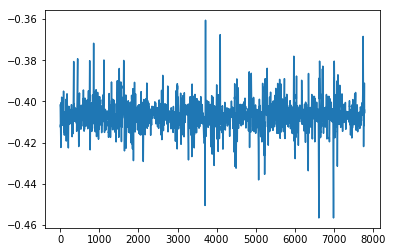

In [19]:
plt.plot(predicted)

In [643]:
# # need to split into examples of length T such that T-n are used as predictors to predict the Tth element
# def generateTSeries(ts,T):
#     predictors = []
#     predictee = []
#     # Drop if there aren't enough rows to make a set of T
#     if len(ts)%T != 0:
#         ts = ts.drop(ts.tail(len(ts)%T).index,inplace = True)
#     # Start grouping
#     predictee = ts.iloc[T-1::T,:]
#     tsNew = ts.drop(ts.iloc[T-1::T,:].index)
#     for count,i in enumerate(range(0,len(ts),T-1)):
#         if tsNew.iloc[i:i+T-1].empty:
#             continue
#         predictors.append((tsNew.iloc[i:i+T-1]))
#     return predictors,predictee
            
        

In [644]:
# predictors,predictee = generateTSeries(A2ZData,60)
# predictors2, _ = generateTSeries(Nifty50Data,60)

In [645]:
# predictorsFin = []
# for predictor in predictors:
#     predictorsFin.append(predictor['close'].values)
# predictorsFin = np.array(predictorsFin)
# predicteeFin = np.array(predictee['close'].values)
# # Code for later:
# # yTemp = np.zeros(x.shape[0])
# # cur = predicteeFin[0]
# # for count,i in enumerate(predicteeFin):
# # #     print(i-cur < -0.30)
# #     if count==0:
# #         continue
# #     if i - cur > 0.30:
# #         yTemp[count] = 1 #Buy
# #         cur = i
# #     elif i - cur < -0.30:
# #         yTemp[count] = -1 #Sell
# #         cur = i
# #     else:
# #         yTemp[count] = 0 #Do Nothing

In [646]:

# s = np.arange(predictorsFin.shape[0])
# np.random.shuffle(s)
# x = predictorsFin[s]
# y = predicteeFin[s]


In [648]:
# #transform the data into train and test
# from sklearn import preprocessing
# # scaler_x=preprocessing.MinMaxScaler(feature_range=(-1,1))
# # x=np.array(x).reshape(x.shape[0],x.shape[1])
# # x=scaler_x.fit_transform(x)

# # scaler_y=preprocessing.MinMaxScaler(feature_range=(-1,1))
# # y=np.array(y).reshape((len(y),1))
# # y=scaler_y.fit_transform(y)

# #the train set
# train_end= int(0.8*x.shape[0])
# x_train=x[0:train_end,]
# x_test=x[train_end:]
# y_train=y[0:train_end]
# y_test=y[train_end:]
# x_train=x_train.reshape(x_train.shape+(1,))
# x_test=x_test.reshape(x_test.shape+(1,))
# x_train.shape


(519, 59, 1)

In [654]:
# x_train.shape
# y_train.shape
# 519*59

30621